# Mini Project 3 - Group 12

In [1]:
#Importing Necessary Libraries
import os
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from collections import Counter
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Loading the dataset
def load_data(directory):
    data = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
                content = file.read()
                data.append(content)
    return data

directory = 'Articles' # Replace with the path to your text files
raw_data = load_data(directory)


# 1. Preprocessing and exploratory data analysis

# Preprocessing of data

**Corpus Building**

In [3]:
#Pre-processing the data
def preprocess_data(raw_data):
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    preprocessed_data = []
    for document in raw_data:
        tokenized_words = word_tokenize(document.lower())
        cleaned_words = [word for word in tokenized_words if word.isalnum() and word not in stop_words]
        lemmatized_words = [lemmatizer.lemmatize(word) for word in cleaned_words]
        preprocessed_data.append(lemmatized_words)
    return preprocessed_data

preprocessed_data = preprocess_data(raw_data)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kaush\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kaush\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
preprocessed_data = ' '.join([' '.join(doc) for doc in preprocessed_data])

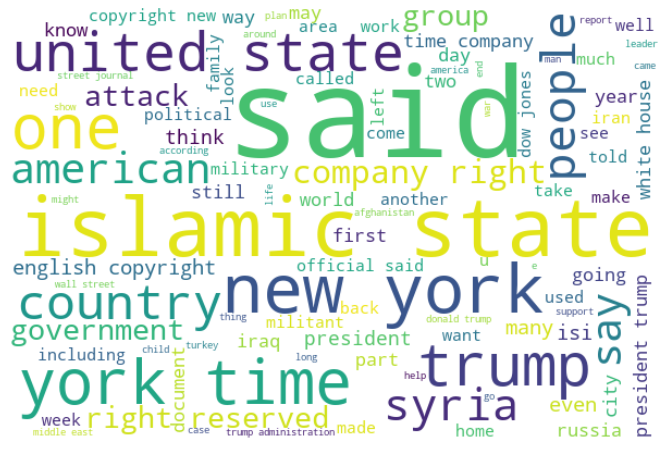

In [5]:
# Word Cloud Representation of Most commonly used Words
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_cloud(text, max_words=100):
    wordcloud = WordCloud(width=600, height=400, background_color='white', max_words=max_words).generate(text)

    plt.figure(figsize=(16, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

generate_word_cloud(preprocessed_data)


**Data Pre-processing**

In [6]:
import re

def extract_metadata(text):
    metadata = {}
    # Extract metadata here (e.g., title, author, date, etc.)
    # Example: metadata['title'] = re.search('TITLE_PATTERN', text).group(1)
    
    # Remove metadata from the text
    cleaned_text = re.sub('METADATA_PATTERN', '', text)
    return metadata, cleaned_text

def preprocess_data(raw_data):
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    preprocessed_data = []
    metadata_list = []

    for document in raw_data:
        metadata, cleaned_text = extract_metadata(document)
        metadata_list.append(metadata)

        tokenized_words = word_tokenize(cleaned_text.lower())
        cleaned_words = [re.sub(r'[^\w\s]', '', word) for word in tokenized_words if word.isalnum() and word not in stop_words]
        lemmatized_words = [lemmatizer.lemmatize(word) for word in cleaned_words]
        preprocessed_data.append(lemmatized_words)
    
    return metadata_list, preprocessed_data

metadata_list, preprocessed_data = preprocess_data(raw_data)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kaush\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kaush\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
